### An Analysis of 2018 AirBnb USA Data by Arushi Patel, Jerry Sun and Nathan Laieke

### Introduction

Firstly, we will import all the necessary packages to help us better understand and come to a conclusion based on the data. We chose to look into this particular AirBnb Data set because there was a hypothesized idea that some numerical or categorical variables could have a direct impact on certain listings receiving more bookings and reviews in comparison to others. Some factors which could potentially impact the number of bookings or number of reviews would include price, descriptions, and locations. In order to analyze the data, we need to see where the data has missing values and other errors which could lead to potential complications in visualizing the data. 

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels as smodel
import sklearn
from sklearn import datasets, linear_model, metrics
import statsmodels.formula.api as stmf
import os
import re
import unicodedata
#import nltk
# Imports from sklearn for ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression

!pip install wordcloud
from wordcloud import WordCloud,STOPWORDS

     |████████████████████████████████| 371 kB 4.3 MB/s eta 0:00:01


### STEP 1: Importing and Cleaning Data

First, let’s take a look at all the data to see what variables are available, unnecessary and contain missing values. 

In [3]:

# USA DATA
usaDataFrame = pd.read_csv('AB_US_2020.csv')
del usaDataFrame['neighbourhood_group']
usaDataFrame['coordinates'] = usaDataFrame['latitude'].astype(str) + ', ' + usaDataFrame['longitude'].astype(str)
del usaDataFrame['latitude']
del usaDataFrame['longitude']

# Make city column one of the first few columns
usaDataFrame = usaDataFrame[["id","host_id","name","host_name","city","neighbourhood","room_type","price","minimum_nights","number_of_reviews",
                             "last_review","reviews_per_month","calculated_host_listings_count","availability_365","coordinates"]]
# Group by city and neighborhood and sort by the most number of reviews
usaDataFrame.sort_values(["city","neighbourhood","number_of_reviews"],ascending = [True,True,False])

#Dealing with nulls in USA data
usaDataFrame.isnull().sum()
usaData2 = usaDataFrame
#check for the num of unique data points in each feature
usaData2.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
usaData2.select_dtypes('int').apply(pd.Series.nunique, axis = 0)
usaData2.select_dtypes('float').apply(pd.Series.nunique, axis = 0)
usaDataFrame

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,host_id,name,host_name,city,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,coordinates
0,38585,165529,Charming Victorian home - twin beds + breakfast,Evelyne,Asheville,28804,Private room,60,1,138,16/02/20,1.14,1,0,"35.65146, -82.62791999999999"
1,80905,427027,French Chic Loft,Celeste,Asheville,28801,Entire home/apt,470,1,114,07/09/20,1.03,11,288,"35.59779, -82.5554"
2,108061,320564,Walk to stores/parks/downtown. Fenced yard/Pet...,Lisa,Asheville,28801,Entire home/apt,75,30,89,30/11/19,0.81,2,298,"35.6067, -82.55563000000001"
3,155305,746673,Cottage! BonPaul + Sharky's Hostel,BonPaul,Asheville,28806,Entire home/apt,90,1,267,22/09/20,2.39,5,0,"35.57864, -82.59578"
4,160594,769252,Historic Grove Park,Elizabeth,Asheville,28801,Private room,125,30,58,19/10/15,0.52,1,0,"35.61442, -82.54127"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226025,45506143,25973146,"DC Hidden In Plain ""Site""",Marci,Washington D.C.,"Downtown, Chinatown, Penn Quarters, Mount Vern...",Entire home/apt,104,1,0,NaN,NaN,2,99,"38.90388, -77.02973"
226026,45511428,231133074,DC 3 BR w/ screen porch 3 blck to metro w/ par...,Thomas,Washington D.C.,"Brookland, Brentwood, Langdon",Entire home/apt,151,2,0,NaN,NaN,1,300,"38.92082, -76.99098000000001"
226027,45514685,33758935,Charming Penthouse Apt w/ Rooftop Terrace in L...,Bassem,Washington D.C.,"Shaw, Logan Circle",Entire home/apt,240,2,0,NaN,NaN,1,173,"38.91117, -77.03354"
226028,45516412,23193071,Adams Morgan/Nat'l Zoo 1 BR Apt #32,Michael,Washington D.C.,"Kalorama Heights, Adams Morgan, Lanier Heights",Entire home/apt,60,21,0,NaN,NaN,5,362,"38.926629999999996, -77.04436"


As seen above, some interesting features which don’t seem necessary include neighborhood group and coordinates. In the data the city is already included as a location so the coordinates would not be helpful in analyzing the variables which affect bookings. A problem with the neighborhood group is that the values are not consistent, much of that information is missing and it would not be helpful to locate and fill in. In order to better organize the information the city column is moved further to the left. The nulls in the data need to be handled as well.

Above, the data is grouped by city and neighborhood, and then sorted by the most number of reviews. This is important because the number of reviews will be the variable that implies many bookings, since there is not data on the number of bookings. Reviews whether positive or negative imply that the listing is heavily interacted with. If a listing had a few negative reviews customers would be less inclined to book that room thus, they would not write a review. 

### STEP 2: Observing Numerical Features 
In order to infer how we can help sellers receive more bookings, we need to understand how the data behaves. We can do this through data visualization, specifically through the  trends in the variables. Taking this cleaned data, we will create graphs that will reveal those trends, both broad and specific. 

First we can start by looking for outliers in the data. In order to do this, we plotted the density distribution for each numerical feature.

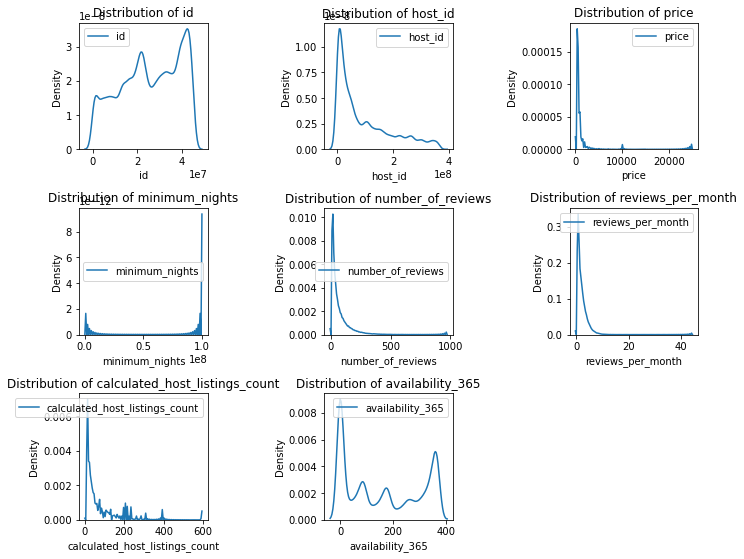

In [4]:
#Outliers
distr_numeric = usaData2.select_dtypes(include=('int', 'float')).columns
plt.figure(figsize = (10,10))

for i, each in enumerate(distr_numeric):
    plt.subplot(4,3,i+1)
    sb.kdeplot(usaData2[each])
    plt.title('Distribution of %s' %each)
    plt.xlabel('%s' %each); plt.ylabel('Density')
    plt.tight_layout()

According to these plotted distributions, price, reviews per month, minimum nights, and reviews contain outliers which skew the data. This can be combated by setting bounds for the data. This has its positives and negatives, since it would narrow the data set but it would lead to less error when trying to apply machine learning onto the data set. 

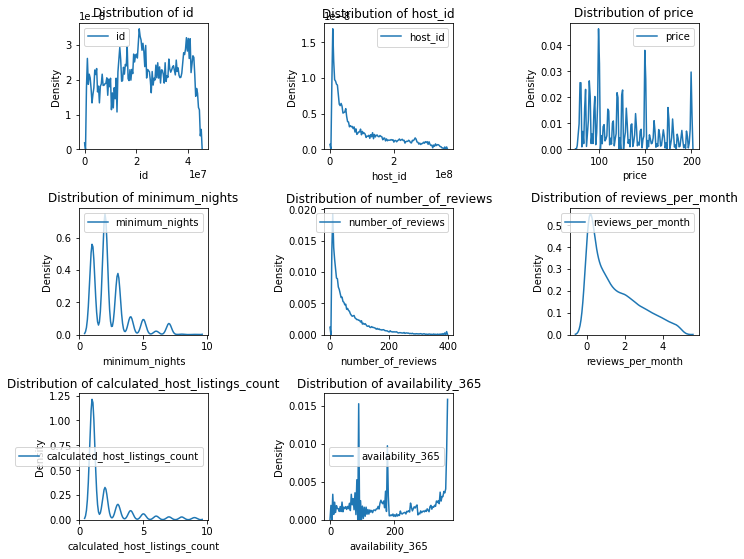

In [5]:
ubound = .75
lbound = .25
cleaned = usaData2[usaData2['price'].between(usaData2['price'].quantile(lbound), usaDataFrame['price'].quantile(ubound), inclusive = True)]
cleaned = cleaned[cleaned['number_of_reviews']>0]
cleaned = cleaned[cleaned['reviews_per_month']<5]
cleaned = cleaned[cleaned['minimum_nights']<10]
cleaned = cleaned[cleaned['calculated_host_listings_count']<10]
cleaned = cleaned[cleaned['number_of_reviews']<400]
#Any other ideas of what limits to put?
numeric_Cleaned = cleaned.select_dtypes(include = ('float', 'int')).columns
plt.figure(figsize=(10,10))
for i, each in enumerate(numeric_Cleaned):
    plt.subplot(4,3,i+1)
    sb.kdeplot(cleaned[each], bw = .2)
    plt.title('Distribution of %s' %each)
    plt.xlabel('%s' %each); plt.ylabel('Density')
    plt.tight_layout()
    
#Words to describe things we can learn from the below graphs.
cleanedUsaData = cleaned.copy(deep=True)


In the distribution above there are a few key observations that we can take away. Firstly, most of the listings are priced as whole numbers, listings require 1-2 minimally, and hosts usually have one listing.

### STEP 3: Exploring Numerical Features

Now that there is an understanding of each feature’s behaviors, we can take a closer look into specific variables and how they behave together. The goal is to now find a correlation between the number of reviews and some variable. Also looking at the relationships between price and other variables will help to rule out price as being the all determining factor when booking an AirBnb.

reviews_per_month                -0.066397
number_of_reviews                -0.056982
id                               -0.007779
host_id                           0.007055
calculated_host_listings_count    0.026635
availability_365                  0.045928
minimum_nights                    0.093901
price                             1.000000
Name: price, dtype: float64

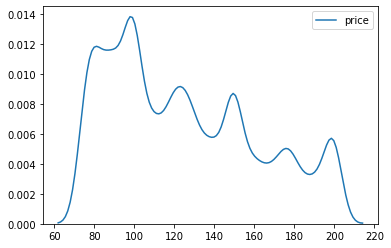

In [6]:
#Explore Numeric Features
#Feature 1 Price:
cleanedUsaData['price'].describe()
cleanedUsaData
sb.kdeplot(cleanedUsaData['price'])


correlated = cleanedUsaData.corr()['price'].sort_values()
correlated


In the above graph we can see price plotted with its correlations to other variables, it does not seem like there is any significance that affects the number of reviews per month.

Now we will look at the minimum nights that customers usually have to stay in the listings. 

(array([16902., 22272., 11317.,  3346.,     0.,  2846.,   646.,  2059.,
           85.,    40.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

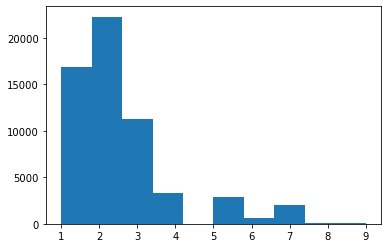

In [7]:
#Feature 2: Minimum Nights
plt.hist(cleanedUsaData['minimum_nights'])
#plot comparing reviews per month and minimum nights

The number of nights seems to vary from 1 to 9 nights. This could hint towards listings that have lower required nights being more likely to be booked. Most of the listings do have a low minimum night so it would be inefficient to say that having a high minimum night means less revenue but it can be said that most listings on AirBnb follow a trend. The trend is that most bookings have a lower minimum number of nights. 

The location of each listing can play a key role in who books those locations. The most popular listings are probably from major cities. This can be inferred based on the fact that populous cities are most likely to be visited for temporary periods of time. 

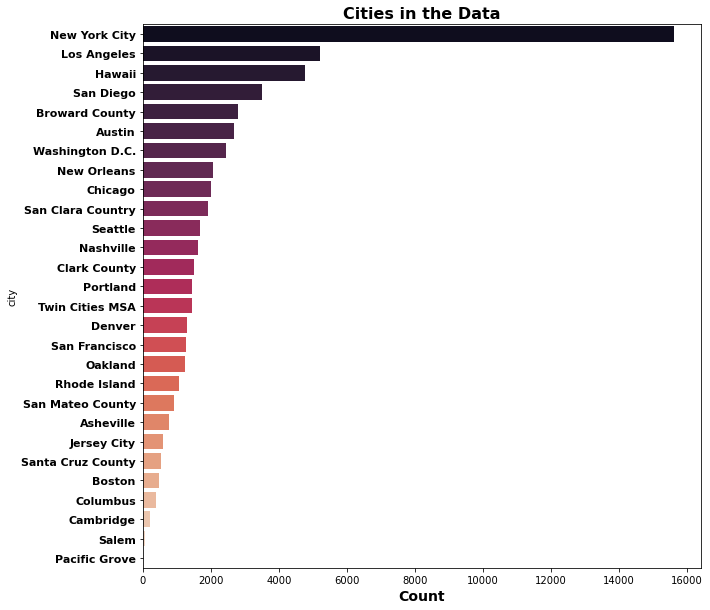

In [8]:
#Cities on the data
plt.figure(figsize=(10, 10))
n = sb.countplot(y=cleanedUsaData['city'], order = cleanedUsaData['city'].value_counts().index,palette='rocket')
n.set_yticklabels(n.get_yticklabels(), fontsize=11, fontweight='bold')
n.set_title('Cities in the Data', fontsize=16, fontweight= 'bold')
n.set_xlabel('Count', fontsize=14, fontweight='bold')
plt.show()

This graph confirms our hypothesis that most of the data is from populous cities. The most populous city being New York City. Thus, any conclusion we come to based on this data is a better reflection of New York City listings.

Now that we know which cities are the most popular, we can take a deeper look into which cities have the highest number of reviews. 

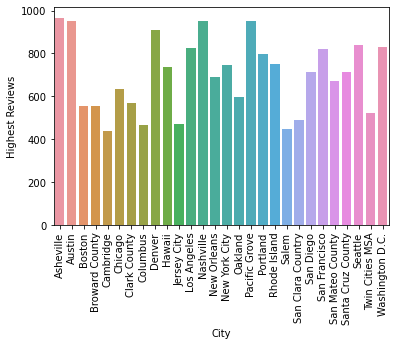

In [9]:
# highest number of reviews per city
grouped = usaDataFrame.groupby(["city"])["number_of_reviews"].max()
reviews = []
temp = []
for city in grouped :
    reviews.append(city)


sb.barplot(grouped.keys(),reviews) #graph only showing highest reviews per city

plt.xticks(plt.xticks()[0], rotation=90)
plt.ylabel("Highest Reviews")
plt.xlabel("City")
plt.show()


Here we can see that New York City, despite having many reviews, was out performed by cities like Pacific Grove, Nashville, Denver, Austin, and Asheville. This could be an indicator that the data received for these locations is not diverse enough to sufficiently compete with the New York City data. Although they have higher reviews, they do have significantly lower listings and thus bookings than more populous cities. 

Now we will compare the price of the highest reviewed listing in each city. 

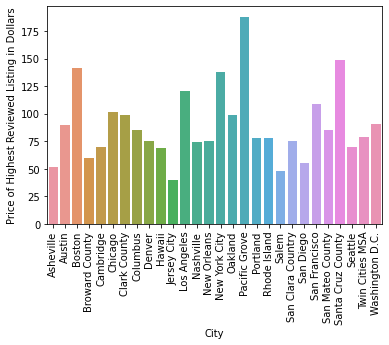

In [10]:
# price of most popular listings in each city
temp = []
for index,row in usaDataFrame.iterrows():
    if (row["number_of_reviews"]==grouped[row["city"]]):
        temp.append(row["price"])

sb.barplot(grouped.keys(),temp) 
plt.xticks(plt.xticks()[0], rotation=90)
plt.ylabel("Price of Highest Reviewed Listing in Dollars")
plt.xlabel("City")
plt.show()


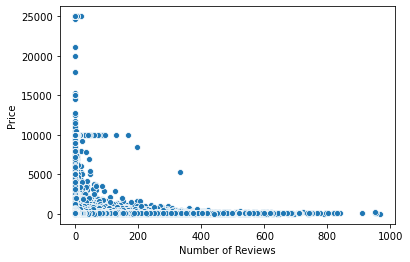

In [11]:
# overall correlation between number of reviews and price
sb.scatterplot(usaDataFrame["number_of_reviews"],usaDataFrame["price"])
plt.xlabel("Number of Reviews")
plt.ylabel("Price")
plt.show()

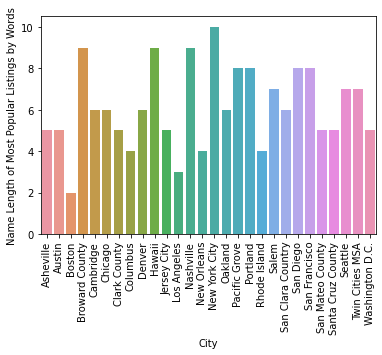

In [12]:
#length of name of most popular listings
name_len = []
usaDataFrame["name"] = usaDataFrame["name"].astype(str)
for index,row in usaDataFrame.iterrows():
    if (row["number_of_reviews"]==grouped[row["city"]]):
        name_len.append(len(row["name"].split(" ")))
sb.barplot(grouped.keys(),name_len)
plt.xticks(plt.xticks()[0], rotation=90)
plt.ylabel("Name Length of Most Popular Listings by Words")
plt.xlabel("City")
plt.show()


Here there was some surprising data. The highest priced location was not New York City, instead it was Pacific Grove. This implies that there is no correlation between high prices and less reviews. Since Pacific Grove has both high reviews and high prices. Now we can rule out price as being a large detrimental factor. To confirm this we will plot the correlation between price and number of reviews below. 

Another possible factor can be the number of rooms. 

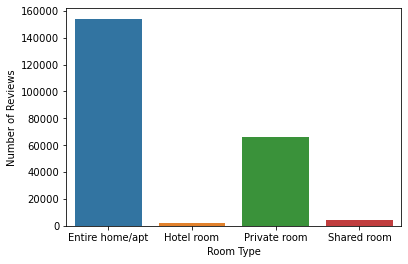

In [13]:
#correlation between number of reviews and room type
rooms = usaDataFrame.groupby(["room_type"])["number_of_reviews"].count()
reviews= []
for room in rooms:
    reviews.append(room)
sb.barplot(rooms.keys(),reviews)
plt.xlabel("Room Type")
plt.ylabel("Number of Reviews")
plt.show()


The average number of rooms is apparently on the regular the entire apartment or house. Since that is clearly the majority of the data, where it outnumbers the other options greatly, it could not possibly have a dramatic effect on the number of bookings a listing can get. But we will return to this distribution later to verify this hypothesis. 

Lastly, we will be looking at the relationship between the length of characters in a listing  description and the number of reviews. We hypothesize that this feature could have the most direct and impactful effect on the number of reviews a listing can get. 

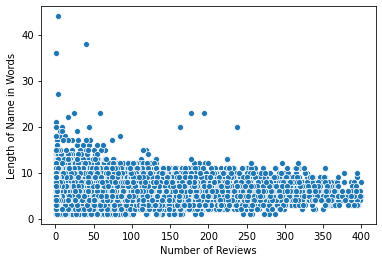

In [14]:
# Overall length of name in characters vs number of reviews

name_len = []
cleanedUsaData["name"] = cleanedUsaData["name"].astype(str)
for name in cleanedUsaData["name"]:
    name_len.append(len(name.split(" ")))
sb.scatterplot(cleanedUsaData["number_of_reviews"],name_len)
plt.xlabel("Number of Reviews")
plt.ylabel("Length of Name in Words")
plt.show()

Although this graph appears to be quite clustered, it shows that the fewer words a listing description has, the greater the number of reviews.

Now that we know that these two are related, we can explore how the number of words impact the number of reviews. What are the descriptions made of? Are there any trends within these descriptions? What descriptions would, on average, get higher reviews?

### STEP 4: Explore Categorical Data:
First, we will clear up our interest in the type of room. By cleaning the data for room type and assigning it to each city, we can see how different cities offer different room types. 

In [15]:
#Step 4: Explore Catergorial Data
encoder = LabelEncoder()

encoder.fit(cleanedUsaData['room_type'])
encoder_room = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(encoder_room)
cleanedUsaData['room_type'] = encoder.transform(cleanedUsaData['room_type'])

encoder.fit(cleanedUsaData['city'])
encoder_city = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(encoder_city)
usaData2['city'] = encoder.transform(usaData2['city'])

{'Entire home/apt': 0, 'Hotel room': 1, 'Private room': 2, 'Shared room': 3}
{'Asheville': 0, 'Austin': 1, 'Boston': 2, 'Broward County': 3, 'Cambridge': 4, 'Chicago': 5, 'Clark County': 6, 'Columbus': 7, 'Denver': 8, 'Hawaii': 9, 'Jersey City': 10, 'Los Angeles': 11, 'Nashville': 12, 'New Orleans': 13, 'New York City': 14, 'Oakland': 15, 'Pacific Grove': 16, 'Portland': 17, 'Rhode Island': 18, 'Salem': 19, 'San Clara Country': 20, 'San Diego': 21, 'San Francisco': 22, 'San Mateo County': 23, 'Santa Cruz County': 24, 'Seattle': 25, 'Twin Cities MSA': 26, 'Washington D.C.': 27}


Text(0.5, 0, 'room_type')

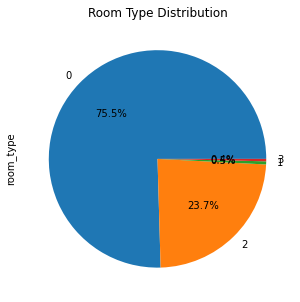

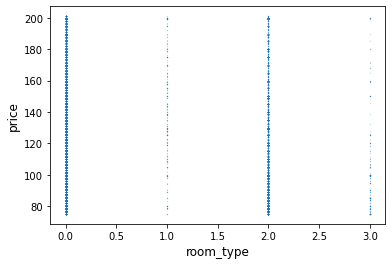

In [16]:
#Room Types: Most rooms are homes, apartments or private rooms
#&Relabel the graph&
plt.figure(figsize = (5,5))
cleanedUsaData.room_type.value_counts().plot.pie(autopct="%.1f%%", title = "Room Type Distribution")
fig, n = plt.subplots()
n.scatter(x = cleanedUsaData['room_type'], y = cleanedUsaData['price'], s = 0.01)
plt.ylabel('price', fontsize=12)
plt.xlabel('room_type', fontsize =12)

Following these results, we concluded that room-type is not at all influential to the number of reviews. 

Now the only feature that matters is the descriptions. We will now explore the descriptions. What are they made of? Does their content explain the number of reviews each listing gets?

Text(0.5, 1.0, 'Word length')

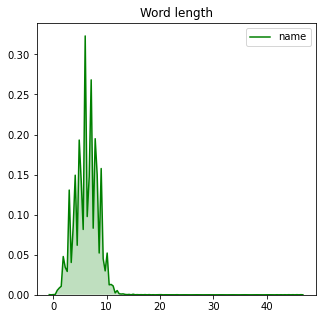

In [17]:
#Explore the Length of Descriptions and Words in listings
lengths = cleanedUsaData['name'].apply(lambda n: len(str(n).split()))
lengths.describe()

plt.figure(figsize=(5, 5))
sb.kdeplot(lengths, shade=True, color='green').set_title('Word length')


We now apply lambda to find the lengths for the number of words in the name of the listing. All the titles seem to be short. We can follow this lead and see what words in these short titles lead to more reviews. 

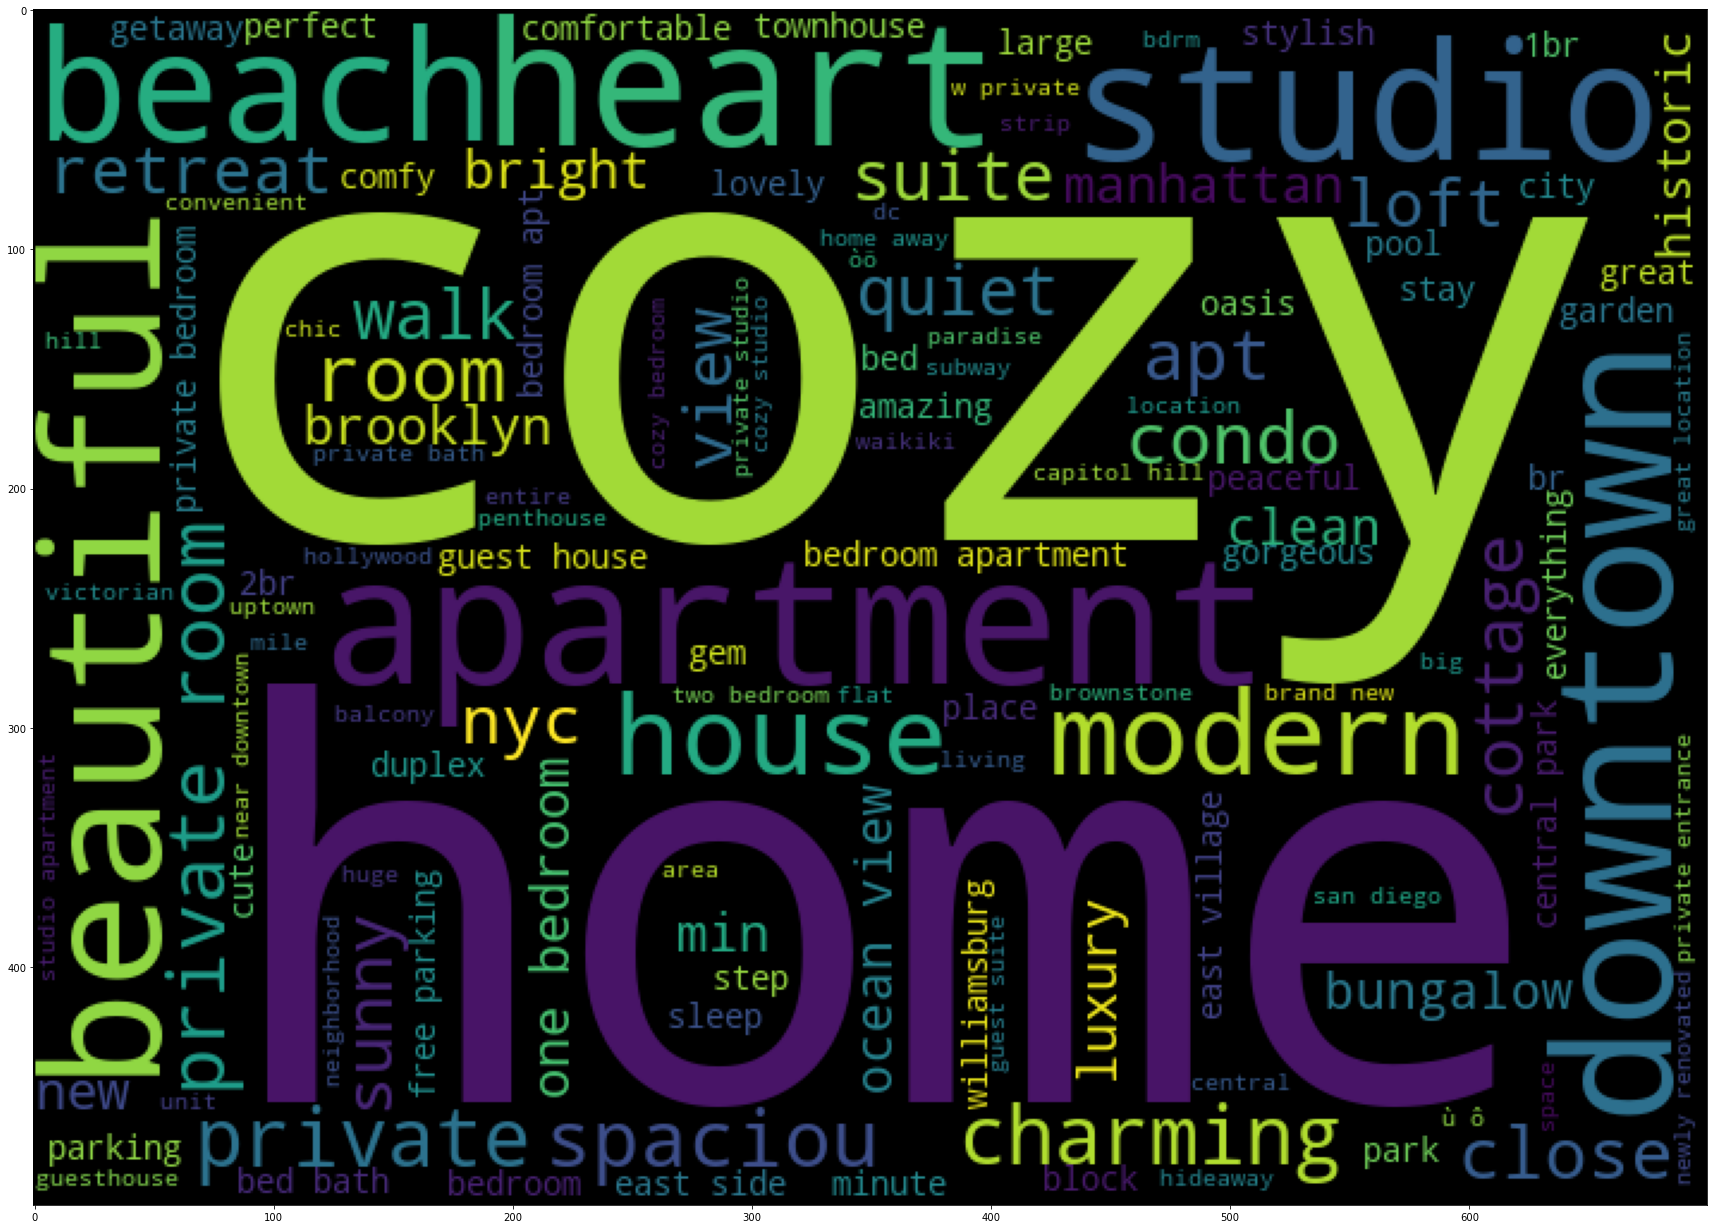

In [18]:
#Exploring the most used word in the Listing
#MAKE A WORD CLOUD
y = cleanedUsaData['name'].astype(str)
listToString= ' '.join([str(elem) for elem in y if elem not in STOPWORDS]).lower()
plt.figure(figsize = (30, 30))
wordcloud = WordCloud(width=700, height = 500, min_font_size=10).generate(listToString)
plt.imshow(wordcloud)

Above, we created a world cloud to see which words are most present in popular listings. Some words are clearly much larger than others, which indicates that it is seen repeatedly throughout the listing titles. Thus implying a relationship between title and the number or reviews. 

### Step 5: Machine Learning Analysis

Now that we have seen the relations between the number of reviews a listing gets and factors such as price, name length, room type, and the most popular words in listings, we want to find out how we can correlate the number of reviews with the length of a listings name. We first can do a linear regression to find a general trend amongst name length in words, having popular words, and the number of reviews a listing gets.

We first will do a linear regression to see if there is a correlation between name length and having more reviews.

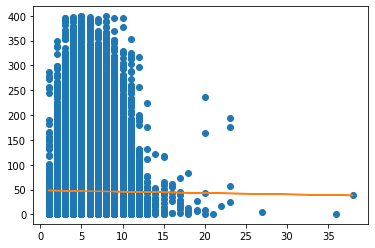

In [19]:
# creates a name length column based on number of words in name
cleanedUsaData["name_length"] = cleanedUsaData["name"].apply(lambda x: len(x.split(" ")))
# get listings that have less than 40 words
cleanedUsaData = cleanedUsaData[cleanedUsaData['name_length']<40]

# linear regression
from sklearn.linear_model import LinearRegression
X_train = np.array(cleanedUsaData["name_length"]).reshape(-1,1)

Y_train = np.array(cleanedUsaData["number_of_reviews"])


lin_reg = LinearRegression().fit(X_train,Y_train)

y_predict = lin_reg.predict(X_train)


# Manual way of fitting a linear regression to verify
X_train = np.array(cleanedUsaData["name_length"])
plt.plot(X_train, Y_train, 'o')
m, b = np.polyfit(X_train, Y_train, 1)
plt.plot(X_train, m*X_train + b)


As we can see, the linear regression line has a slightly negative correlation between the number of words in a listing's name and the number of reviews it gets. The scatterplot also shows that the most popular listings (defined by us as having over 100 reviews) lie within having 10 to 12 words in the listing names.

We will use this observation to predict if having less than 15 words and having popular words in a listing's name will make that listing popular (having over 100 reviews). We will use the Bag of Words model to first clean names and get popular words.

In [20]:
# import libraries
import re
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
!pip install autocorrect
from autocorrect import Speller
!pip install pyspellchecker
from spellchecker import SpellChecker



     |████████████████████████████████| 1.4 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 738 kB 7.3 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434673 sha256=1bfcd878afc639f03cf97a77da581849643e646ea44e7aef7e5693adac2253b0
  Stored in directory: /home/jovyan/.cache/pip/wheels/ff/d5/7b/f1fb4e1e1603b2f01c2424dd60fbcc50c12ef918bafc44b155
Successfully built nltk


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     |████████████████████████████████| 621 kB 6.6 MB/s eta 0:00:01
  Created wheel for autocorrect: filename=autocorrect-2.2.2-py3-none-any.whl size=621488 sha256=978268e80474d885d4f718e2b38c2d67be1409075dc95b41b4f172b4fd7dee4f
  Stored in directory: /home/jovyan/.cache/pip/wheels/be/ff/2c/f37b5edb4d5a940b481ff52b507198743af7657161029a92eb
Successfully built autocorrect
     |████████████████████████████████| 1.9 MB 7.6 MB/s eta 0:00:01


In [67]:
# bag of words
data = []
spell = Speller(fast = True)
stemmer = PorterStemmer()
# names less than 10 words in length
t = cleanedUsaData[cleanedUsaData["name_length"]<15]["name"]
for i in t:
    text_msg = i
    text_msg = str(text_msg)
    # clean name to have alphabet characters only
    text_msg = re.sub('[^A-Za-z]',' ',text_msg)
    text_msg = text_msg.lower()
    # tokenize the word
    tokenize_name = word_tokenize(text_msg)
    msg_process = []
    # check to see if the word is a stop word
    for j in tokenize_name:
        if j not in set(stopwords.words('english')):
            # spell check the word and only process the stem
            msg_process.append(spell(stemmer.stem(j)))
    text = ' '.join(msg_process)
    data.append(text)

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# get the listings that have over 200 reviews and have a name length of less than 10 words to test against
reviews_100 = cleanedUsaData[cleanedUsaData["name_length"]<15]["number_of_reviews"].apply(lambda x : x > 100)

# gets the top 20 popular words in all names
matrix = CountVectorizer(max_features=20)
X = matrix.fit_transform(data).toarray()
y = reviews_100

X_train, X_test, y_train, y_test = train_test_split(X,y)
from sklearn.naive_bayes import GaussianNB

# Guassian classifier
classifier = GaussianNB()
classifier.fit(X_train,y_train)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)

print(accuracy)

0.7503868667160062


As we can see, the model accurately predicts around 75 percent of the time if a listing that has less than 15 words in its name is popular if it includes words in the top 20 most popular words for all listings.

In [69]:
# how many popular listings
popular = 0
for val in y_pred:
    if val == True:
        popular+=1
popular/len(y_pred)

0.16140752203458253

Only about 16 percent of listings that have names less than 15 words have over 100 reviews. This makes sense with the linear regression model as the line trends at around 50 reviews for listings that have less than 15 words. This means that there are a lot of listings that are below 100 reviews in this range (which is why the linear regression line is weighted down), but this range of name lengths also contains the most listings that have over 100 reviews out of all name lengths as seen in the linear regression scatterplot.   

### Conclusion

In conclusion, listings in general that have less than 15 words tend to have a better chance of becoming popular and having over 100 reviews. People tend to prefer more concise descriptions of properties they would like to stay in, and particular descriptors such as cozy, beautiful, apartment, and home are most commonly used in listings across the U.S. For this dataset, we determined a successful listing as having many reviews (assuming that people who review listings stayed there). This does not necessarily mean that the listing is great for consumers since it could have many bad reviews, rather that the seller did a good job of making money from the listing assuming that reviewers payed money and stayed at the property. While we made a generalization about the descriptions of listings affecting number of reviews, there are definitely other factors such as geographic location of different cities and different neighborhoods that will affect listing reviews. These factors could be explored in more depth outside the scope of this project to get a more nuanced analysis of listing reviews.   